## Configuração e Instalação de Dependências

In [1]:
%pip install transformers torch pandas matplotlib seaborn requests radon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.1 MB/s eta 0:00:00


## Obter Releases do Projeto

In [2]:
import os
import time
import requests

repo_owner = "block"
repo_name = "goose"

# Fallback seguro para token: Colab, env var ou anon
try:
    from google.colab import userdata
    github_token = userdata.get("GITHUB_ACCESS_TOKEN")
except Exception:
    github_token = os.environ.get("GITHUB_TOKEN") or os.environ.get("GITHUB_ACCESS_TOKEN")

headers = {
    "Accept": "application/vnd.github.v3+json"
}
if github_token:
    headers["Authorization"] = f"token {github_token}"

# Helper para obter SHA mesmo em tags anotadas

def get_ref_sha(owner, repo, tag, headers):
    ref_url = f"https://api.github.com/repos/{owner}/{repo}/git/ref/tags/{tag}"
    r = requests.get(ref_url, headers=headers)
    if r.status_code != 200:
        return None
    obj = r.json().get("object", {})
    if obj.get("type") == "tag":  # tag anotada
        tag_obj = requests.get(obj.get("url", ""), headers=headers)
        if tag_obj.status_code == 200:
            return tag_obj.json().get("object", {}).get("sha")
    return obj.get("sha")

# Obter releases (limitar às 5 mais recentes)
releases_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/releases"
response = requests.get(releases_url, headers=headers, params={"per_page": 5})

if response.status_code == 200:
    releases = response.json()[:5]
    print(f"Obtidas {len(releases)} releases mais recentes")
    print("\nReleases que serão analisadas:")
    for r in releases:
        print(f"- {r['tag_name']}: {r['name']}")
else:
    print(f"Erro: {response.status_code}")
    releases = []

Obtidas 5 releases mais recentes

Releases que serão analisadas:
- v1.16.1: v1.16.1
- v1.16.0: v1.16.0
- v1.15.0: v1.15.0
- v1.14.0: v1.14.0
- v1.13.2: v1.13.2


## Obter Arquivos Python das Releases

In [3]:
import base64

RATE_LIMIT_SLEEP = 0.4
MAX_FILES_PER_RELEASE = 40  # inclui testes
MAX_RETRIES = 3


def fetch_with_retries(url, headers, params=None):
    for attempt in range(MAX_RETRIES):
        resp = requests.get(url, headers=headers, params=params or {})
        if resp.status_code in (401, 403, 404):
            print(f"  ⚠️ Erro {resp.status_code} em {url}")
            return None
        if resp.status_code == 200:
            return resp
        sleep_time = RATE_LIMIT_SLEEP * (2 ** attempt)
        print(f"  Retry {attempt+1}/{MAX_RETRIES} em {sleep_time:.1f}s (status {resp.status_code})")
        time.sleep(sleep_time)
    return None


def get_python_files(owner, repo, tag, headers, max_files=MAX_FILES_PER_RELEASE):
    """Obtém arquivos Python de uma release (usa SHA para lidar com tags anotadas)."""
    sha = get_ref_sha(owner, repo, tag, headers) or tag
    tree_url = f"https://api.github.com/repos/{owner}/{repo}/git/trees/{sha}"
    resp = fetch_with_retries(tree_url, headers, params={"recursive": 1})
    if not resp:
        return []

    tree = resp.json().get("tree", [])
    py_files = [f for f in tree if f.get("path", "").endswith(".py") and f.get("type") == "blob"]

    # inclui testes, limitando volume
    return py_files[:max_files]


def get_file_content(owner, repo, file_path, ref, headers):
    """Obtém conteúdo completo do arquivo (sem truncar)."""
    content_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{file_path}"
    resp = fetch_with_retries(content_url, headers, params={"ref": ref})
    if not resp:
        return None
    data = resp.json()
    encoded = data.get("content", "")
    if not encoded:
        return None
    return base64.b64decode(encoded).decode("utf-8", errors="ignore")


# Coletar código das 5 RELEASES MAIS RECENTES
code_samples = []
max_releases = 5

print(f"Analisando as {max_releases} releases mais recentes...\n")

for idx, release in enumerate(releases[:max_releases], 1):
    tag = release["tag_name"]
    print(f"[{idx}/{max_releases}] Processando release {tag}...")

    py_files = get_python_files(repo_owner, repo_name, tag, headers, max_files=MAX_FILES_PER_RELEASE)
    print(f"  Encontrados {len(py_files)} arquivos Python")

    for file_info in py_files:
        content = get_file_content(repo_owner, repo_name, file_info["path"], tag, headers)
        if content and len(content) > 50:
            code_samples.append({
                "release": tag,
                "file": file_info["path"],
                "code": content  # sem truncar; vamos fatiar por função depois
            })
        time.sleep(RATE_LIMIT_SLEEP)

print(f"\n{'='*60}")
print(f"Total de amostras coletadas: {len(code_samples)}")
print(f"Releases analisadas: {max_releases}")
print(f"{'='*60}")

Analisando as 5 releases mais recentes...

[1/5] Processando release v1.16.1...
  Encontrados 13 arquivos Python
[2/5] Processando release v1.16.0...
  Encontrados 13 arquivos Python
[3/5] Processando release v1.15.0...
  Encontrados 11 arquivos Python
[4/5] Processando release v1.14.0...
  Encontrados 11 arquivos Python
[5/5] Processando release v1.13.2...
  Encontrados 11 arquivos Python
  ⚠️ Erro 403 em https://api.github.com/repos/block/goose/contents/examples/mcp-wiki/src/mcp_wiki/__init__.py
  ⚠️ Erro 403 em https://api.github.com/repos/block/goose/contents/examples/mcp-wiki/src/mcp_wiki/__main__.py
  ⚠️ Erro 403 em https://api.github.com/repos/block/goose/contents/examples/mcp-wiki/src/mcp_wiki/server.py
  ⚠️ Erro 403 em https://api.github.com/repos/block/goose/contents/recipe-scanner/decode-training-data.py
  ⚠️ Erro 403 em https://api.github.com/repos/block/goose/contents/scripts/bench-postprocess-scripts/generate_leaderboard.py
  ⚠️ Erro 403 em https://api.github.com/repos/bl

## Três Modelos + Heurísticas AST

- CodeBERT-Insecure (classificação binária de insegurança)
- CodeBERT (embeddings para duplicação/estrutura)
- CodeT5 (embeddings para complexidade/feature envy)
- Heurísticas AST como baseline estruturado

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from tqdm import tqdm

MODELS_INFO = {
    "CodeBERT-Insecure": "mrm8488/codebert-base-finetuned-detect-insecure-code",
    "CodeBERT": "microsoft/codebert-base",
    "CodeT5": "Salesforce/codet5-base",
}

tokenizers = {}
models = {}

for name, model_id in MODELS_INFO.items():
    print(f"Carregando {name} ({model_id})...")
    tokenizers[name] = AutoTokenizer.from_pretrained(model_id)
    if name == "CodeBERT-Insecure":
        models[name] = AutoModelForSequenceClassification.from_pretrained(model_id)
    else:
        models[name] = AutoModel.from_pretrained(model_id)
    models[name].eval()

id2label = models["CodeBERT-Insecure"].config.id2label
positive_id = next((idx for idx, label in id2label.items() if "1" in str(label) or "POS" in str(label).upper()), 1)
print("Labels do modelo de insegurança:", id2label)
print(f"Indice considerado positivo para insegurança: {positive_id}")
print("\n✅ Modelos carregados e rotulagem validada!")

Carregando CodeBERT-Insecure (mrm8488/codebert-base-finetuned-detect-insecure-code)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Carregando CodeBERT (microsoft/codebert-base)...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Carregando CodeT5 (Salesforce/codet5-base)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Labels do modelo de insegurança: {0: 'LABEL_0', 1: 'LABEL_1'}
Indice considerado positivo para insegurança: 1

✅ Modelos carregados e rotulagem validada!


## Definir Code Smells a Serem Analisados

Baseado na taxonomia do Refactoring Guru:

In [5]:
CODE_SMELLS = {
    "Long Method": "Funções muito longas e complexas",
    "Large Class": "Classe com muitas responsabilidades",
    "Duplicate Code": "Código duplicado",
    "Feature Envy": "Função usa mais dados de outra classe",
    "Insecure Code": "Uso inseguro de funções, entradas ou permissões"
}

print("Code Smells a serem analisados:")
for smell, description in CODE_SMELLS.items():
    print(f"  • {smell}: {description}")

Code Smells a serem analisados:
  • Long Method: Funções muito longas e complexas
  • Large Class: Classe com muitas responsabilidades
  • Duplicate Code: Código duplicado
  • Feature Envy: Função usa mais dados de outra classe
  • Insecure Code: Uso inseguro de funções, entradas ou permissões


## Funções de Análise Específicas por Modelo

Cada modelo utiliza uma estratégia diferente:

In [10]:
import ast
import re
from radon.complexity import cc_visit

DANGEROUS_PATTERNS = [
    r"eval\(",
    r"exec\(",
    r"pickle\\.load",
    r"subprocess\\.Popen",
    r"os\\.system",
    r"yaml\\.load\(",
    r"shell=True",
]

def normalize_code(text: str) -> str:
    cleaned = []
    for line in text.splitlines():
        stripped = line.strip()
        if not stripped or stripped.startswith("#"):
            continue
        cleaned.append(stripped)
    return "".join(cleaned)

def collect_units(code: str):
    """Extrai funções e classes com metadados básicos."""
    units = []
    lines = code.splitlines()

    class Collector(ast.NodeVisitor):
        def visit_ClassDef(self, node):
            start = getattr(node, "lineno", 1)
            end = getattr(node, "end_lineno", start)
            snippet = "\n".join(lines[start - 1 : end])
            method_count = sum(
                isinstance(n, (ast.FunctionDef, ast.AsyncFunctionDef)) for n in node.body
            )
            units.append(
                {
                    "type": "class",
                    "name": node.name,
                    "lineno": start,
                    "end_lineno": end,
                    "loc": end - start + 1,
                    "code": snippet,
                    "method_count": method_count,
                }
            )
            self.generic_visit(node)

        def visit_FunctionDef(self, node):
            start = getattr(node, "lineno", 1)
            end = getattr(node, "end_lineno", start)
            snippet = "\n".join(lines[start - 1 : end])
            attr_external = sum(
                isinstance(n, ast.Attribute)
                and isinstance(n.value, ast.Name)
                and n.value.id != "self"
                for n in ast.walk(node)
            )
            attr_self = sum(
                isinstance(n, ast.Attribute)
                and isinstance(n.value, ast.Name)
                and n.value.id == "self"
                for n in ast.walk(node)
            )
            units.append(
                {
                    "type": "function",
                    "name": node.name,
                    "lineno": start,
                    "end_lineno": end,
                    "loc": end - start + 1,
                    "code": snippet,
                    "external_attrs": attr_external,
                    "self_attrs": attr_self,
                }
            )
            self.generic_visit(node)

        visit_AsyncFunctionDef = visit_FunctionDef

    try:
        Collector().visit(ast.parse(code))
    except SyntaxError:
        return []
    return units


def complexity_map(code: str):
    try:
        blocks = cc_visit(code)
        return {(b.name, b.lineno): b.complexity for b in blocks}
    except Exception:
        return {}


def detect_duplicates(units):
    hashes = {}
    for u in units:
        norm = normalize_code(u["code"])
        if len(norm) < 50:
            continue
        h = hash(norm)
        hashes.setdefault(h, []).append(u)
    dup_ids = set()
    for _, us in hashes.items():
        if len(us) > 1:
            dup_ids.update(id(u) for u in us)
    return dup_ids


def heuristic_insecure(code: str) -> bool:
    return any(re.search(p, code) for p in DANGEROUS_PATTERNS)


def predict_insecure(code: str):
    """Avalia insegurança por chunks para não truncar contexto."""
    max_prob = 0.0
    for start in range(0, len(code), 1000):
        chunk = code[start : start + 1000]
        inputs = tokenizers["CodeBERT-Insecure"](chunk, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            logits = models["CodeBERT-Insecure"](**inputs).logits
            probs = torch.softmax(logits, dim=1)
            pos_prob = probs[0, positive_id].item()
            max_prob = max(max_prob, pos_prob)
            if pos_prob >= 0.60:
                return True, max_prob
    return False, max_prob


def analyze_codebert(unit_code: str):
    """Usa CodeBERT para sinais de duplicação/estrutura por unidade."""
    inputs = tokenizers["CodeBERT"](unit_code, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = models["CodeBERT"](**inputs)
    embeddings = outputs.last_hidden_state
    variance = torch.var(embeddings).item()
    norm = torch.norm(embeddings.mean(dim=1)).item()

    smells = []
    if variance < 0.25:
        smells.append("Duplicate Code")
    if norm > 115:
        smells.append("Long Method")
    return smells


def analyze_codet5(unit_code: str, loc: int):
    """Usa CodeT5 para complexidade; complementa AST."""
    inputs = tokenizers["CodeT5"](unit_code, truncation=True, max_length=512, return_tensors="pt")
    # Fix: Add decoder_input_ids as T5 model expects it
    inputs["decoder_input_ids"] = inputs["input_ids"].clone()
    with torch.no_grad():
        outputs = models["CodeT5"](**inputs)
    pooled = outputs.last_hidden_state.mean(dim=1)
    score = torch.norm(pooled).item()

    smells = []
    if score > 110 and loc > 60:
        smells.append("Long Method")
    if score > 120:
        smells.append("Feature Envy")
    return smells

print("✅ Funções de análise carregadas:")
print("  • AST/metrics para baseline")
print("  • CodeBERT-Insecure para detecção binária")
print("  • CodeBERT (embeddings) para duplicação/complexidade")
print("  • CodeT5 (embeddings) para complexidade/envidia")

✅ Funções de análise carregadas:
  • AST/metrics para baseline
  • CodeBERT-Insecure para detecção binária
  • CodeBERT (embeddings) para duplicação/complexidade
  • CodeT5 (embeddings) para complexidade/envidia


## Executar Análise Completa

Processando todas as amostras de código com os 3 modelos:

In [11]:
results = []
manual_checks = []

print(f"Analisando {len(code_samples)} amostras de código com 3 modelos + AST...\n")

for sample in tqdm(code_samples, desc="Processando amostras"):
    code = sample["code"]
    units = collect_units(code)
    comp_map = complexity_map(code)
    dup_ids = detect_duplicates(units)

    for u in units:
        comp_value = comp_map.get((u["name"], u["lineno"]), 0)

        # Baseline AST
        smells_ast = []
        if u["type"] == "function" and (u["loc"] > 80 or comp_value > 15):
            smells_ast.append("Long Method")
        if u["type"] == "class" and (u["loc"] > 200 or u.get("method_count", 0) > 15):
            smells_ast.append("Large Class")
        if u["type"] == "function" and (u.get("external_attrs", 0) > u.get("self_attrs", 0) + 4):
            smells_ast.append("Feature Envy")
        if id(u) in dup_ids:
            smells_ast.append("Duplicate Code")

        # Modelo CodeBERT-Insecure
        insecure_flag, prob = predict_insecure(u["code"])
        smells_insecure = ["Insecure Code"] if (insecure_flag or heuristic_insecure(u["code"])) else []

        # Modelo CodeBERT
        smells_codebert = analyze_codebert(u["code"])

        # Modelo CodeT5
        smells_codet5 = analyze_codet5(u["code"], u.get("loc", 0))

        for smell in smells_ast:
            entry = {
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "unit_type": u["type"],
                "code_smell": smell,
                "model": "AST-Heuristics",
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
            }
            results.append(entry)

        for smell in smells_insecure:
            entry = {
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "unit_type": u["type"],
                "code_smell": smell,
                "model": "CodeBERT-Insecure",
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
            }
            results.append(entry)

        for smell in smells_codebert:
            entry = {
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "unit_type": u["type"],
                "code_smell": smell,
                "model": "CodeBERT",
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
            }
            results.append(entry)

        for smell in smells_codet5:
            entry = {
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "unit_type": u["type"],
                "code_smell": smell,
                "model": "CodeT5",
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
            }
            results.append(entry)

        # coletar amostras para revisão manual
        if len(manual_checks) < 5 and (smells_ast or smells_insecure or smells_codebert or smells_codet5):
            snippet = u["code"][:400].replace("\n", " ")
            manual_checks.append({
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "code_smell": (smells_ast + smells_insecure + smells_codebert + smells_codet5)[0],
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
                "snippet": snippet,
            })

print(f"\n{'='*60}")
print(f"✅ Análise concluída!")
print(f"Total de code smells detectados: {len(results)}")
print(f"{'='*60}")

print("\nAmostras para verificação manual (primeiras 5):")
for i, item in enumerate(manual_checks, 1):
    print(f"[{i}] {item['code_smell']} em {item['file']}::{item['unit_name']} (LOC={item['loc']}, CC={item['complexity']:.1f}, p_insec={item['insecure_prob']:.2f})")
    print(f"     snippet: {item['snippet'][:180]}...")

Analisando 49 amostras de código com 3 modelos + AST...



Processando amostras: 100%|██████████| 49/49 [24:17<00:00, 29.75s/it]


✅ Análise concluída!
Total de code smells detectados: 518

Amostras para verificação manual (primeiras 5):
[1] Feature Envy em .github/scripts/send_key.py::main (LOC=34, CC=6.0, p_insec=1.00)
     snippet: def main():     # Environment variable validation     required_envs = ["GITHUB_TOKEN", "GITHUB_SHA", "GITHUB_REPOSITORY", "PROVISIONING_API_KEY", "EMAIL_API_KEY"]     missing = [en...
[2] Feature Envy em .github/scripts/send_key.py::get_pr_number_from_sha (LOC=19, CC=2.0, p_insec=1.00)
     snippet: def get_pr_number_from_sha():     token = os.getenv("GITHUB_TOKEN")     repo = os.getenv("GITHUB_REPOSITORY")     sha = os.getenv("GITHUB_SHA")      url = f"https://api.github.com/...
[3] Insecure Code em .github/scripts/send_key.py::fetch_pr_body (LOC=13, CC=2.0, p_insec=1.00)
     snippet: def fetch_pr_body(pr_number, github_token, repo_full_name):     print("🔍 Fetching PR body...")     pr_url = f"https://api.github.com/repos/{repo_full_name}/pulls/{pr_number}"     t...
[4] Feature Env

In [12]:
results = []
manual_checks = []

print(f"Analisando {len(code_samples)} amostras de código com 3 modelos + AST...\n")

for sample in tqdm(code_samples, desc="Processando amostras"):
    code = sample["code"]
    units = collect_units(code)
    comp_map = complexity_map(code)
    dup_ids = detect_duplicates(units)

    for u in units:
        comp_value = comp_map.get((u["name"], u["lineno"]), 0)

        # Baseline AST
        smells_ast = []
        if u["type"] == "function" and (u["loc"] > 80 or comp_value > 15):
            smells_ast.append("Long Method")
        if u["type"] == "class" and (u["loc"] > 200 or u.get("method_count", 0) > 15):
            smells_ast.append("Large Class")
        if u["type"] == "function" and (u.get("external_attrs", 0) > u.get("self_attrs", 0) + 4):
            smells_ast.append("Feature Envy")
        if id(u) in dup_ids:
            smells_ast.append("Duplicate Code")

        # Modelo CodeBERT-Insecure
        insecure_flag, prob = predict_insecure(u["code"])
        smells_insecure = ["Insecure Code"] if (insecure_flag or heuristic_insecure(u["code"])) else []

        # Modelo CodeBERT
        smells_codebert = analyze_codebert(u["code"])

        # Modelo CodeT5
        smells_codet5 = analyze_codet5(u["code"], u.get("loc", 0))

        for smell in smells_ast:
            entry = {
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "unit_type": u["type"],
                "code_smell": smell,
                "model": "AST-Heuristics",
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
            }
            results.append(entry)

        for smell in smells_insecure:
            entry = {
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "unit_type": u["type"],
                "code_smell": smell,
                "model": "CodeBERT-Insecure",
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
            }
            results.append(entry)

        for smell in smells_codebert:
            entry = {
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "unit_type": u["type"],
                "code_smell": smell,
                "model": "CodeBERT",
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
            }
            results.append(entry)

        for smell in smells_codet5:
            entry = {
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "unit_type": u["type"],
                "code_smell": smell,
                "model": "CodeT5",
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
            }
            results.append(entry)

        # coletar amostras para revisão manual
        if len(manual_checks) < 5 and (smells_ast or smells_insecure or smells_codebert or smells_codet5):
            snippet = u["code"][:400].replace("\n", " ")
            manual_checks.append({
                "release": sample["release"],
                "file": sample["file"],
                "unit_name": u["name"],
                "code_smell": (smells_ast + smells_insecure + smells_codebert + smells_codet5)[0],
                "loc": u.get("loc"),
                "complexity": comp_value,
                "insecure_prob": prob,
                "snippet": snippet,
            })

print(f"\n{'='*60}")
print(f"✅ Análise concluída!")
print(f"Total de code smells detectados: {len(results)}")
print(f"{'='*60}")

print("\nAmostras para verificação manual (primeiras 5):")
for i, item in enumerate(manual_checks, 1):
    print(f"[{i}] {item['code_smell']} em {item['file']}::{item['unit_name']} (LOC={item['loc']}, CC={item['complexity']:.1f}, p_insec={item['insecure_prob']:.2f})")
    print(f"     snippet: {item['snippet'][:180]}...")

Analisando 49 amostras de código com 3 modelos + AST...



Processando amostras: 100%|██████████| 49/49 [23:51<00:00, 29.21s/it]


✅ Análise concluída!
Total de code smells detectados: 518

Amostras para verificação manual (primeiras 5):
[1] Feature Envy em .github/scripts/send_key.py::main (LOC=34, CC=6.0, p_insec=1.00)
     snippet: def main():     # Environment variable validation     required_envs = ["GITHUB_TOKEN", "GITHUB_SHA", "GITHUB_REPOSITORY", "PROVISIONING_API_KEY", "EMAIL_API_KEY"]     missing = [en...
[2] Feature Envy em .github/scripts/send_key.py::get_pr_number_from_sha (LOC=19, CC=2.0, p_insec=1.00)
     snippet: def get_pr_number_from_sha():     token = os.getenv("GITHUB_TOKEN")     repo = os.getenv("GITHUB_REPOSITORY")     sha = os.getenv("GITHUB_SHA")      url = f"https://api.github.com/...
[3] Insecure Code em .github/scripts/send_key.py::fetch_pr_body (LOC=13, CC=2.0, p_insec=1.00)
     snippet: def fetch_pr_body(pr_number, github_token, repo_full_name):     print("🔍 Fetching PR body...")     pr_url = f"https://api.github.com/repos/{repo_full_name}/pulls/{pr_number}"     t...
[4] Feature Env

## Tabelas de Resultados

Comparação dos resultados obtidos pelas heurísticas por smell/unidade:

In [13]:
import pandas as pd

df_results = pd.DataFrame(results)

if df_results.empty:
    print("Nenhum code smell detectado. Ajuste limiares ou verifique coleta.")
else:
    # Tabela por smell x modelo
    comparison_table = (
        df_results
        .groupby(["code_smell", "model"])
        .size()
        .reset_index(name="occurrences")
        .pivot(index="code_smell", columns="model", values="occurrences")
        .fillna(0)
        .astype(int)
    )

    print("TABELA COMPARATIVA - Code Smells por Modelo")
    print("="*70)
    print(comparison_table)
    print("\n")

    # Resumo por smell
    print("RESUMO POR CODE SMELL")
    print("="*70)
    summary_by_smell = (
        df_results.groupby("code_smell")
        .size()
        .reset_index(name="total_detections")
        .sort_values("total_detections", ascending=False)
    )
    print(summary_by_smell)
    print("\n")

    # Resumo por release
    print("RESUMO POR RELEASE")
    print("="*70)
    summary_by_release = (
        df_results.groupby("release")
        .size()
        .reset_index(name="total_detections")
        .sort_values("release")
    )
    print(summary_by_release)

    # Resumo por modelo
    print("\nRESUMO POR MODELO")
    print("="*70)
    summary_by_model = (
        df_results.groupby("model")
        .size()
        .reset_index(name="total_detections")
        .sort_values("total_detections", ascending=False)
    )
    print(summary_by_model)

TABELA COMPARATIVA - Code Smells por Modelo
model          AST-Heuristics  CodeBERT-Insecure  CodeT5
code_smell                                              
Feature Envy              123                  0      58
Insecure Code               0                268       0
Large Class                 2                  0       0
Long Method                23                  0      44


RESUMO POR CODE SMELL
      code_smell  total_detections
1  Insecure Code               268
0   Feature Envy               181
3    Long Method                67
2    Large Class                 2


RESUMO POR RELEASE
   release  total_detections
0  v1.13.2                56
1  v1.14.0                83
2  v1.15.0                83
3  v1.16.0               148
4  v1.16.1               148

RESUMO POR MODELO
               model  total_detections
1  CodeBERT-Insecure               268
0     AST-Heuristics               148
2             CodeT5               102


## Análise de Evolução do Projeto

Evolução dos code smells ao longo das releases:

In [14]:
if df_results.empty:
    print("Sem dados para evolução de code smells.")
else:
    evolution = (
        df_results
        .groupby(["release", "code_smell", "model"])
        .size()
        .reset_index(name="count")
    )

    # Tabela pivot para melhor visualização (agregado por smell)
    evolution_pivot = evolution.groupby(["release", "code_smell"]).agg({"count": "sum"}).reset_index()
    evolution_pivot = evolution_pivot.pivot(index="release", columns="code_smell", values="count").fillna(0).astype(int)

    print("EVOLUÇÃO DOS CODE SMELLS POR RELEASE")
    print("="*70)
    print(evolution_pivot)
    print("\n")

    # Total de smells por release
    print("TOTAL DE CODE SMELLS POR RELEASE")
    print("="*70)
    total_by_release = df_results.groupby("release").size().reset_index(name="total_smells").sort_values("release")
    print(total_by_release)

EVOLUÇÃO DOS CODE SMELLS POR RELEASE
code_smell  Feature Envy  Insecure Code  Large Class  Long Method
release                                                          
v1.13.2               17             32            0            7
v1.14.0               28             45            0           10
v1.15.0               28             45            0           10
v1.16.0               54             73            1           20
v1.16.1               54             73            1           20


TOTAL DE CODE SMELLS POR RELEASE
   release  total_smells
0  v1.13.2            56
1  v1.14.0            83
2  v1.15.0            83
3  v1.16.0           148
4  v1.16.1           148


## Visualização Gráfica

Gráfico de evolução dos code smells:

ValueError: Unknown format code 'd' for object of type 'float'

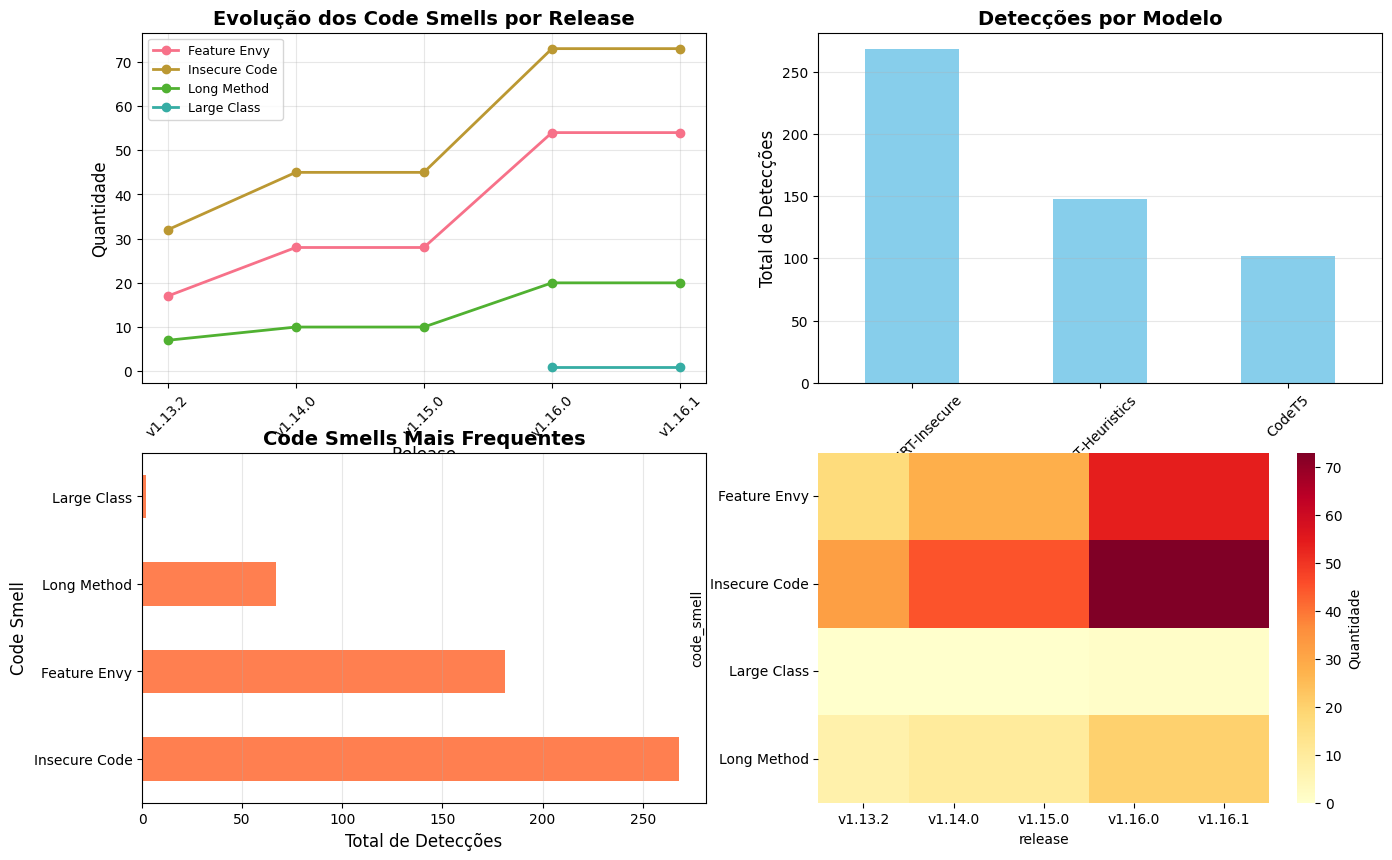

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

if df_results.empty:
    print("Sem dados para plotar.")
else:
    plt.style.use('default')
    sns.set_palette("husl")

    summary_by_smell = (
        df_results.groupby("code_smell")
        .size()
        .reset_index(name="total_detections")
        .sort_values("total_detections", ascending=False)
    )
    summary_by_model = (
        df_results.groupby("model")
        .size()
        .reset_index(name="total_detections")
        .sort_values("total_detections", ascending=False)
    )
    evolution = (
        df_results.groupby(["release", "code_smell"])
        .size()
        .reset_index(name="count")
    )
    evolution_pivot = evolution.pivot(index="release", columns="code_smell", values="count").fillna(0)

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1.1 Evolução dos smells por release
    ax1 = axes[0, 0]
    for smell in evolution["code_smell"].unique():
        data = evolution[evolution["code_smell"] == smell]
        ax1.plot(data["release"], data["count"], marker="o", label=smell, linewidth=2)
    ax1.set_xlabel('Release', fontsize=12)
    ax1.set_ylabel('Quantidade', fontsize=12)
    ax1.set_title('Evolução dos Code Smells por Release', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # 1.2 Comparação por modelo
    ax2 = axes[0, 1]
    summary_by_model.plot(kind='bar', x='model', y='total_detections', ax=ax2, color='skyblue', legend=False)
    ax2.set_xlabel('Modelo', fontsize=12)
    ax2.set_ylabel('Total de Detecções', fontsize=12)
    ax2.set_title('Detecções por Modelo', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

    # 1.3 Code Smells mais frequentes
    ax3 = axes[1, 0]
    summary_by_smell.plot(kind='barh', x='code_smell', y='total_detections', ax=ax3, color='coral', legend=False)
    ax3.set_xlabel('Total de Detecções', fontsize=12)
    ax3.set_ylabel('Code Smell', fontsize=12)
    ax3.set_title('Code Smells Mais Frequentes', fontsize=14, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)

    # 1.4 Heatmap de smells por release
    ax4 = axes[1, 1]
    sns.heatmap(evolution_pivot.T, annot=True, fmt='d', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Quantidade'})
    ax4.set_xlabel('Release', fontsize=12)
    ax4.set_ylabel('Code Smell', fontsize=12)
    ax4.set_title('Heatmap: Smells por Release', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

## Análise e Interpretação dos Resultados

### 1. Efetividade dos Modelos

In [16]:
# Exportar resultados para CSV
if df_results.empty:
    print("Sem resultados para exportar.")
else:
    df_results.to_csv('code_smells_results.csv', index=False)
    summary_by_smell = (
        df_results.groupby("code_smell")
        .size()
        .reset_index(name="total_detections")
        .sort_values("total_detections", ascending=False)
    )
    summary_by_release = (
        df_results.groupby("release")
        .size()
        .reset_index(name="total_detections")
        .sort_values("release")
    )
    summary_by_model = (
        df_results.groupby("model")
        .size()
        .reset_index(name="total_detections")
        .sort_values("total_detections", ascending=False)
    )
    summary_by_smell.to_csv('summary_by_smell.csv', index=False)
    summary_by_release.to_csv('summary_by_release.csv', index=False)
    summary_by_model.to_csv('summary_by_model.csv', index=False)

    print("✅ Resultados exportados com sucesso!")
    print("\nArquivos gerados:")
    print("  • code_smells_results.csv - Todos os resultados detalhados")
    print("  • summary_by_smell.csv - Frequência por code smell")
    print("  • summary_by_release.csv - Frequência por release")
    print("  • summary_by_model.csv - Frequência por modelo")

# Sumário final honesto
print("\n" + "="*70)
print("SUMÁRIO FINAL DA ANÁLISE")
print("="*70)
print(f"Total de amostras analisadas: {len(code_samples)}")
print(f"Total de releases: {len(releases[:5])}")
print(f"Code smells identificados: {len(results)}")
print(f"Tipos de code smells alvo: {', '.join(CODE_SMELLS.keys())}")
if df_results.empty:
    print("⚠️ Nenhum smell detectado com os limiares atuais.")
print("Limitações: heurísticas e modelos podem gerar falsos positivos/negativos; revise as amostras indicadas em 'manual_checks'.")
print("="*70)

✅ Resultados exportados com sucesso!

Arquivos gerados:
  • code_smells_results.csv - Todos os resultados detalhados
  • summary_by_smell.csv - Frequência por code smell
  • summary_by_release.csv - Frequência por release
  • summary_by_model.csv - Frequência por modelo

SUMÁRIO FINAL DA ANÁLISE
Total de amostras analisadas: 49
Total de releases: 5
Code smells identificados: 518
Tipos de code smells alvo: Long Method, Large Class, Duplicate Code, Feature Envy, Insecure Code
Limitações: heurísticas e modelos podem gerar falsos positivos/negativos; revise as amostras indicadas em 'manual_checks'.
